In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()

In [2]:
!pwd

/home/ubuntu/trash-recycling-classifier


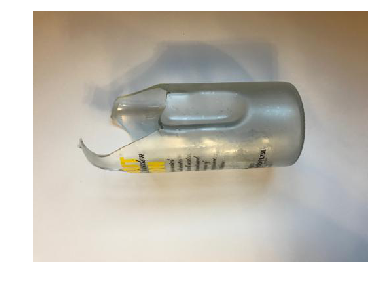

(384, 512, 3)

In [3]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example image from testset
im = Image.open('data/test/glass/glass102.jpg')
imshow(im)
np.array(im).shape



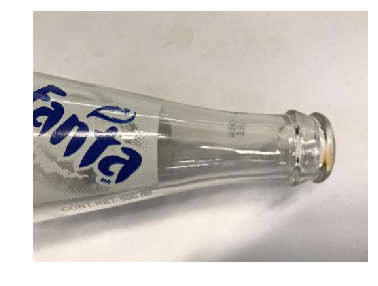

(384, 512, 3)

In [4]:
# Example image from trainset
im = Image.open('data/train/glass/glass177.jpg')
imshow(im)
np.array(im).shape

# Part II. Image Processing

## A. Resize (224x224) & Augment the Images

In [5]:
std_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

In [6]:
img_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(size=256),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomRotation(degrees=30),
                                               transforms.CenterCrop(size=224),
                                               transforms.ToTensor(),
                                               std_norm]),
                   'valid': transforms.Compose([transforms.Resize(size=256),
                                                transforms.CenterCrop(size=224),
                                                transforms.ToTensor(),
                                                std_norm]),
                   'test': transforms.Compose([transforms.Resize(size=256),
                                               transforms.CenterCrop(size=224),
                                               transforms.ToTensor(), 
                                               std_norm])
                  }

### Write functions to display how augmentation works
***Plot a tensor as an image***

In [13]:
#visualization of augmentation process for images in trainset
def imshow_tensor(img, ax=None, title=None):
    

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    img = img.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    # Clip the image pixel values
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    plt.axis('off')

    return ax, img

def img_augment(img_path):
    print(f'Before applying transformation on the image in the train dataset:')
    im = Image.open(img_path)
    imshow(im)
    print(f'After applying different transformation techniques (flip,rotation,etc) on the same image in the train dataset:')
    train_ = img_transforms['train']
    plt.figure(figsize=(20, 20))

    for i in range(20):
        ax = plt.subplot(5, 5, i + 1)
        _ = imshow_tensor(train_(im), ax=ax)
        
    plt.tight_layout()

### Applying Transformations for image augmentations

Before applying transformation on the image in the train dataset:


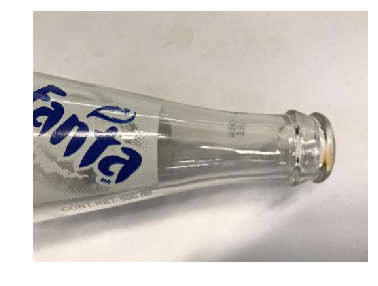

After applying different transformation techniques (flip,rotation,etc) on the same image in the train dataset:


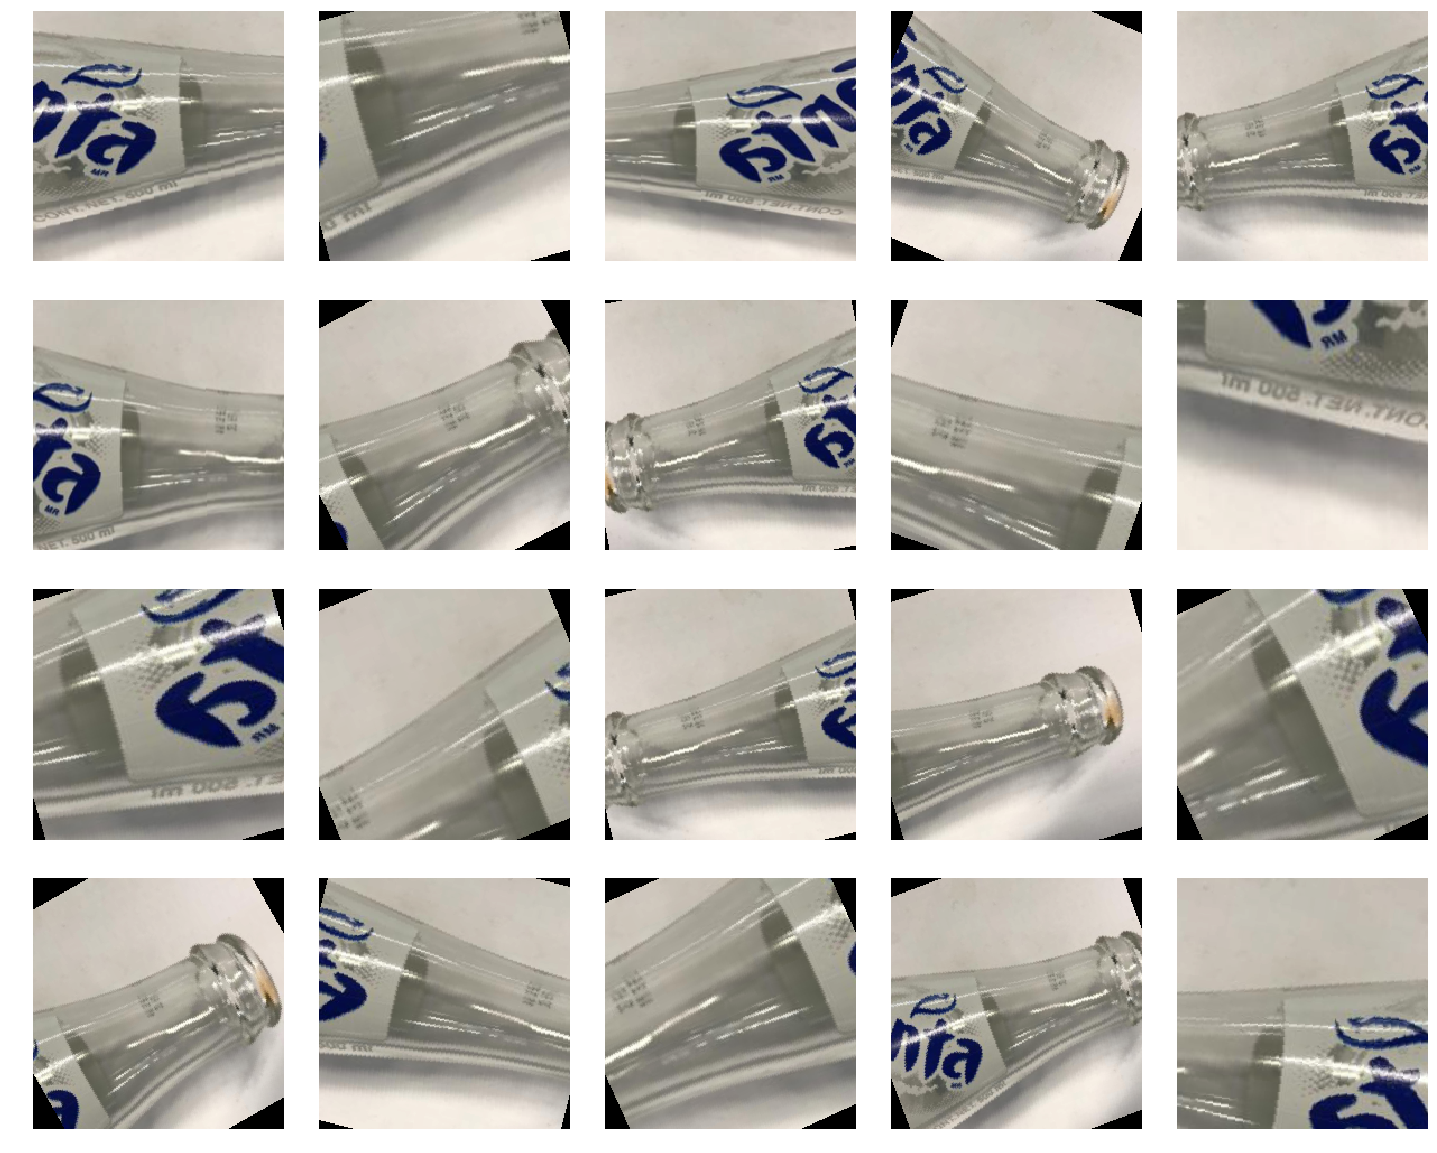

In [14]:
img_augment('data/train/glass/glass177.jpg')

Before applying transformation on the image in the train dataset:


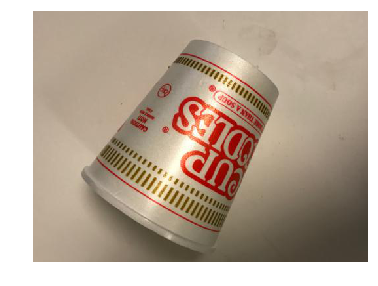

After applying different transformation techniques (flip,rotation,etc) on the same image in the train dataset:


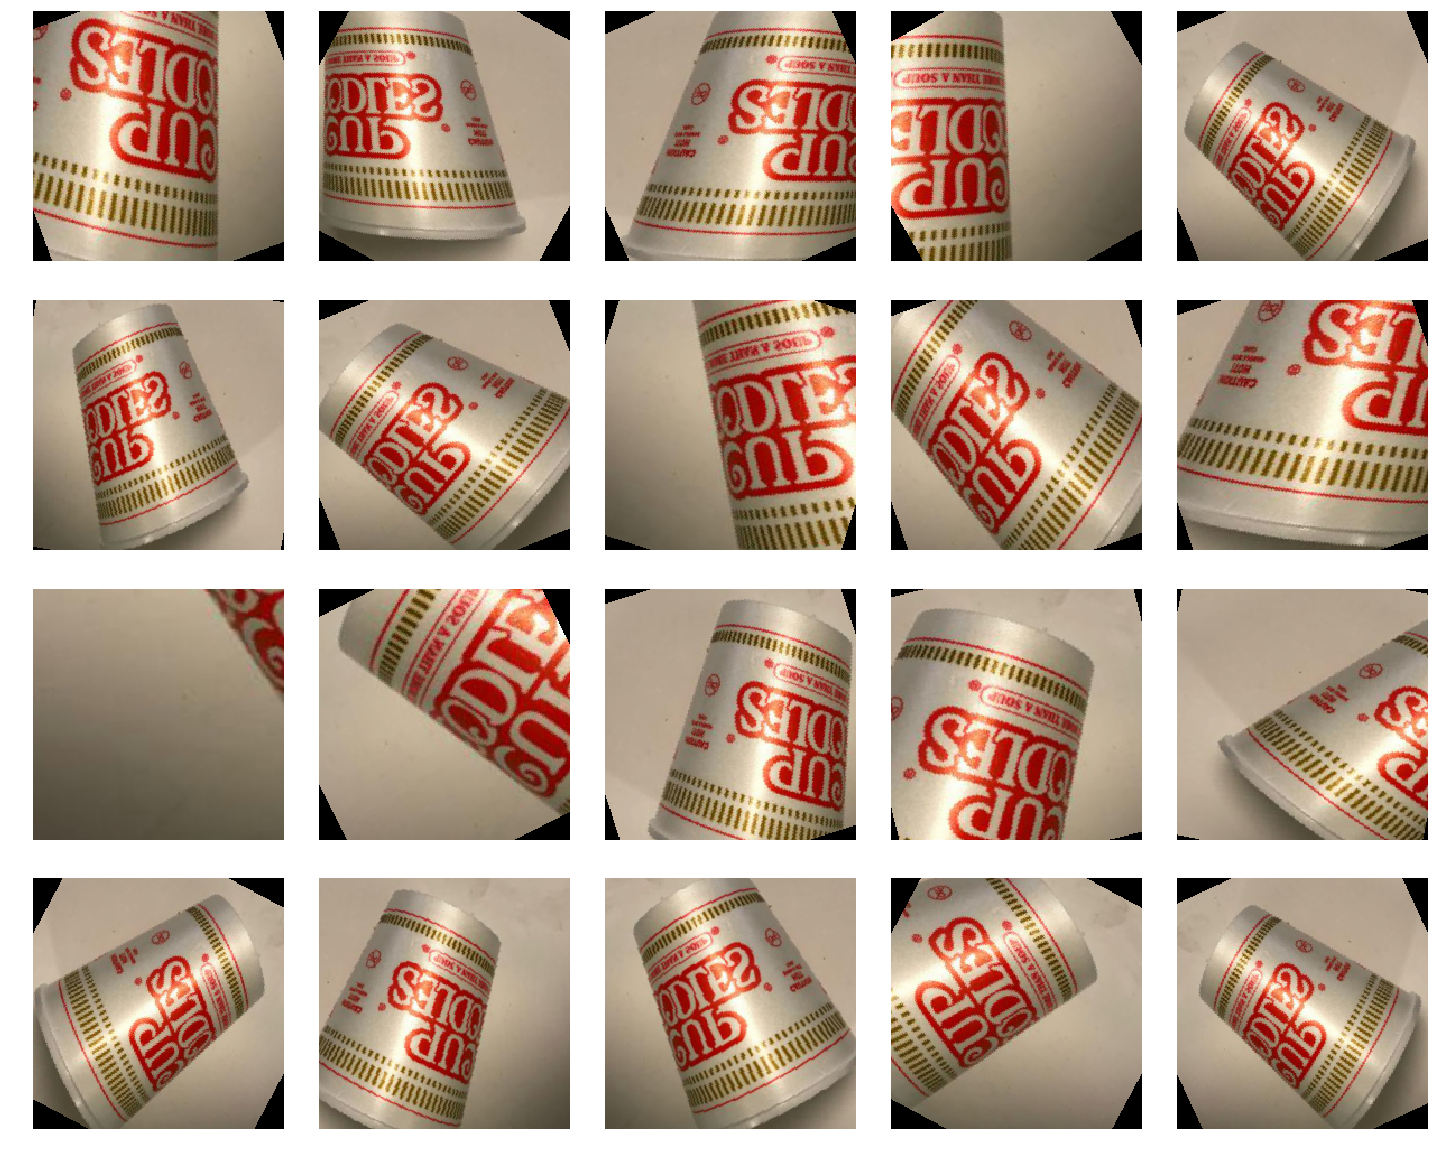

In [15]:
img_augment('data/train/trash/trash87.jpg')

## B. Load the images using `DataLoaders`

In [9]:
train_data_path = "data/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms['train'])

In [10]:
valid_data_path = "data/valid/"
valid_data = torchvision.datasets.ImageFolder(root=valid_data_path,transform=img_transforms['valid'])

In [11]:
test_data_path = "data/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms['test']) 

In [12]:
print(f'there are {len(train_data.classes)} classes in the training dataset.')
print(f'there are {len(valid_data.classes)} classes in the validation dataset.')
print(f'there are {len(test_data.classes)} classes in the testing dataset.')


there are 6 classes in the training dataset.
there are 6 classes in the validation dataset.
there are 6 classes in the testing dataset.


In [17]:
classes = train_data.classes

In [18]:
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

***Consistent with the number of classes being printed out in the previous cells!***

In [19]:
#Params
batch_size = 64
num_workers = 0

In [20]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

In [21]:
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [22]:
print(f'Num. of Images in Training Set: {len(train_loader.dataset)}')
print(f'Num. of Images in Validation Set: {len(valid_loader.dataset)}')
print(f'Num. of Images in Testing Set: {len(test_loader.dataset)}')

Num. of Images in Training Set: 1766
Num. of Images in Validation Set: 378
Num. of Images in Testing Set: 383


#### Move the whole model onto the gpu

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [24]:
save_file_name = 'resnet50-transfer-metric-v1.pt'
checkpoint_path = 'resnet50-transfer-metric-v1.pth'

## Part III. Transfer Learning using pre-trained models

### A. Load the pretrained weight

In [25]:
transfer_model = models.resnet50(pretrained=True) 

In [26]:
transfer_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### B. Freeze the weights for the earlier convolutional layers (lower-level features)

In [28]:
'''Freeze all of the existing layers in the network 
    by setting requires_grad to False'''

for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

### C. Replace the fully connected layers with a classifier specific to this dataset 
***number of outputs = number of classes***

In [23]:
#old_classifier from v1
# transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
# nn.ReLU(),                                 
# nn.Dropout(), nn.Linear(500,6)) 

#transfer_model.fc = nn.Linear(2048, 6, bias=True)

In [29]:
num_inputs = transfer_model.fc.in_features

# Add on classifier
transfer_model.fc = nn.Sequential(
    nn.Linear(num_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, 6), nn.LogSoftmax(dim=1))

transfer_model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
  (4): LogSoftmax()
)

In [30]:
total_params = sum(param.numel() for param in transfer_model.parameters())
print(f'There are {total_params:,} total parameters.')
total_trainable_params = sum(
    param.numel() for param in transfer_model.parameters() if param.requires_grad)
print(f'There are {total_trainable_params:,} training parameters.')

There are 24,034,118 total parameters.
There are 571,526 training parameters.


***Create a mapping of classes to indexes and indexes to classes***

In [27]:

# transfer_model.class_to_idx = train_data.class_to_idx
# transfer_model.idx_to_class = {
#     idx: class_
#     for class_, idx in transfer_model.class_to_idx.items()
# }

# list(transfer_model.idx_to_class.items())[:7]

### D. Train only the customized layers and optimize

In [31]:
transfer_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

### if you scroll down, the last layer of the model now has our customized classifier.

In [35]:
!pip install torch-lr-finder

     |████████████████████████████████| 61kB 10.5MB/s eta 0:00:01



Learning rate search finished. See the graph with {finder_name}.plot()


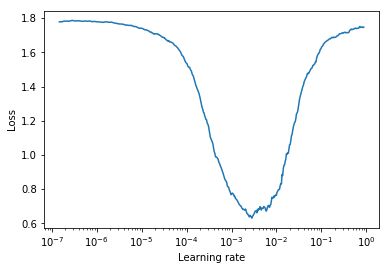

In [38]:
from torch_lr_finder import LRFinder
criterion = nn.NLLLoss()
optimizer_ft = optim.Adam(transfer_model.parameters(), lr=0.0000001)
lr_finder = LRFinder(transfer_model, optimizer_ft, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=500)
lr_finder.reset()
lr_finder.plot()

In [47]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.0003)

In [48]:
# #weights that will be updated by the optimizer during training
# for param in optimizer.param_groups[0]['params']:
#     if param.requires_grad:
#         print(param.shape)

In [49]:
from timeit import default_timer as timer
def train(transfer_model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=5,
          n_epochs=20,
          print_every=2):
    

    # Initialize early stopping
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {transfer_model.epochs} epochs.\n')
    except:
        transfer_model.epochs = 0
        print(f'Let the training begin...\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        transfer_model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = transfer_model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            transfer_model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                transfer_model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = transfer_model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(transfer_model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        transfer_model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        transfer_model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return transfer_model, history

    # Attach the optimizer
    transfer_model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return transfer_model, history

In [50]:
transfer_model, history = train(
    transfer_model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Let the training begin...

Epoch: 1	100.00% complete. 36.47 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9768 	Validation Loss: 0.7944
		Training Accuracy: 66.14%	 Validation Accuracy: 71.96%
Epoch: 3	100.00% complete. 36.13 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6836 	Validation Loss: 0.5758
		Training Accuracy: 76.61%	 Validation Accuracy: 80.69%
Epoch: 5	100.00% complete. 36.28 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.5879 	Validation Loss: 0.4620
		Training Accuracy: 79.73%	 Validation Accuracy: 84.66%
Epoch: 7	100.00% complete. 36.68 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.4902 	Validation Loss: 0.4048
		Training Accuracy: 83.64%	 Validation Accuracy: 86.24%
Epoch: 9	100.00% complete. 36.32 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.4399 	Validation Loss: 0.3741
		Training Accuracy: 84.37%	 Validation Accuracy: 86.24%
Epoch: 11	100.00% complete. 36.37 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.3912 	Validation Los

Text(0.5,1,'Training and Validation Losses vs. # of Epochs')

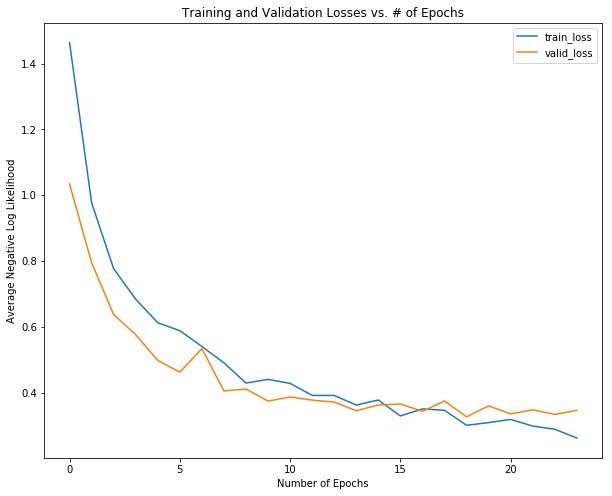

In [51]:
#visualizing the Training and Validation Losses 
plt.figure(figsize=(10, 8))
for i in ['train_loss', 'valid_loss']:
    plt.plot(
        history[i], label=i)
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses vs. # of Epochs')

Text(0.5,1,'Training and Validation Accuracy vs. # of Epochs')

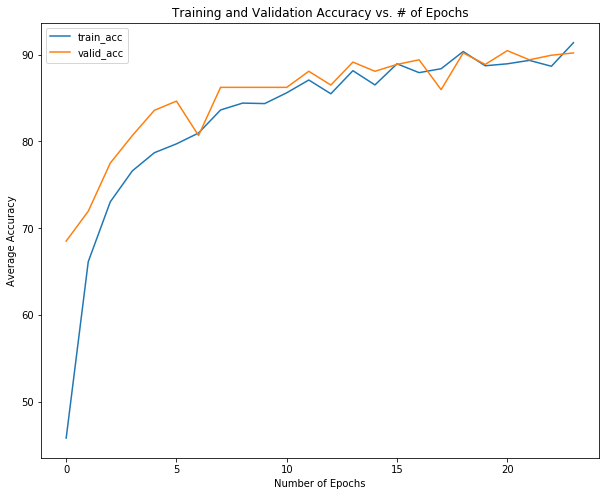

In [52]:
#visualizing accuracy
plt.figure(figsize=(10, 8))
for i in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[i], label=i)
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy vs. # of Epochs')

### Precision, Recall, F1

In [56]:
batch_size = 8
sm = nn.LogSoftmax(dim=1)
def test(transfer_model,test_loader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    
    for ii, (data, target) in enumerate(train_loader):
    # Tensors to gpu
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        transfer_model.eval()
        output = transfer_model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(testloader)*batch_size)
    epoch_loss = running_loss/(len(testloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [57]:
test(transfer_model,test_loader)

RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 11.17 GiB total capacity; 10.41 GiB already allocated; 158.81 MiB free; 324.73 MiB cached)

In [ ]:
def wrong_plot(true,ima,pred,encoder,inv_normalize,n_figures = 12):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()

In [ ]:
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

### Plot confusion matrix 

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
# Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
print(cm)
fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

### Prediction

In [ ]:
def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]
    
    size = len(a)
    if(size>5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
      prediction.append(float(output[:,i]*100))
      clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    plt.bar(clas,prediction)
def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()